# Clasificación de imágenes con modelos de *ensemble*
Este notebook muestra el proceso de análisis, preprocesamiento y entrenamiento de modelos para predecir la clase de imágenes de distintos escenarios.

## 1. Setup

Librerías importadas en el proyecto.

In [1]:
import numpy as np
import pandas as pd

import os
import warnings
import gc
from collections import namedtuple

from IPython.display import IFrame

%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns

from skimage.exposure import rescale_intensity
from skimage.transform import resize

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import FunctionTransformer, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.utils import parallel_backend
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix

Variables globales declaradas en el proyecto.

In [2]:
RANDOM_SEED = 1337
np.random.seed(RANDOM_SEED)

DATASETS = ["train", "test"]
CATEGORIES = {"edificios": 0, "glaciares": 1, "montanas": 2, "mares": 3, "bosques": 4, "calles": 5}
IMG_SHAPE = (150, 150, 3)
OUTPUT_SHAPE = (50, 50, 3)

BATCH_SIZE = 4096
CV_FOLDS = 5

DATA_PATH = os.path.join(os.pardir, "data")  # Path to csv data
INFO_PATH = os.path.join(os.pardir, "info")  # Path to problem info
RESULTS_PATH = os.path.join(os.pardir, "results")  # Path to results files

Funciones de utilidad.

In [3]:
def show_image(img, ax=plt, title=""):
    if ax is plt:
        ax.title(title)
        ax.xticks([])
        ax.yticks([])
    else:
        ax.set_title(title)
        ax.set_xticks([])
        ax.set_yticks([])
    ax.imshow(img)

Enunciado del problema.

In [4]:
IFrame(os.path.join(INFO_PATH, "lab2.pdf"), width=1080, height=920)

## 2. Análisis exploratorio de los datos

En primer lugar, vamos a cargar los datos en memoria.

In [5]:
dataframes = {}

for dataset in DATASETS:
    dataset_path = os.path.join(DATA_PATH, dataset)
    data = []
    for category in os.listdir(dataset_path):
        print(f"Reading category {category} from {dataset} set...")
        category_path = os.path.join(dataset_path, category)
        for file in filter(lambda x: x.endswith(".jpg"), os.listdir(category_path)):
            data.append({
                "img": plt.imread(os.path.join(category_path, file)).astype(np.uint8),
                "label": category
            })
    dataframes[dataset] = pd.DataFrame(data)
    del data

Reading category edificios from train set...
Reading category glaciares from train set...
Reading category montanas from train set...
Reading category mares from train set...
Reading category bosques from train set...
Reading category calles from train set...
Reading category edificios from test set...
Reading category glaciares from test set...
Reading category montanas from test set...
Reading category mares from test set...
Reading category bosques from test set...
Reading category calles from test set...


Con todo cargado en memoria, vamos a hacer una primera visualización de los datos que tenemos. Cogeremos una muestra aleatoria para echar un vistazo a las imágenes.

edificios


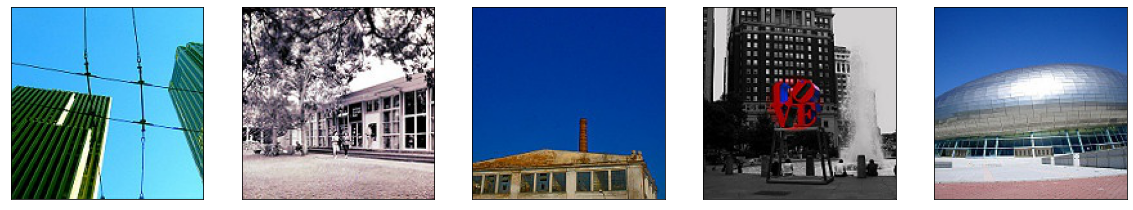

glaciares


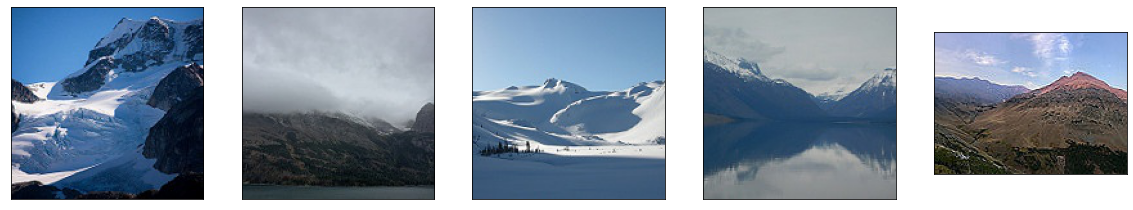

montanas


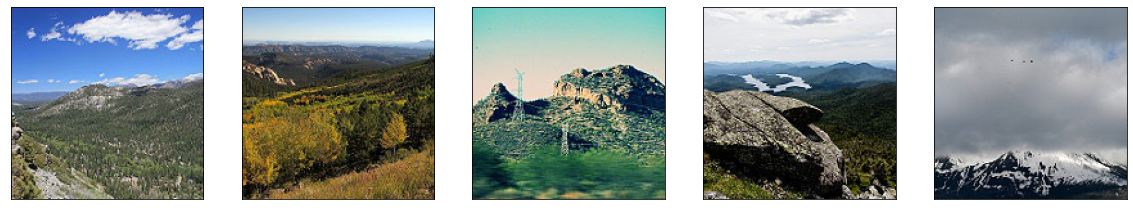

mares


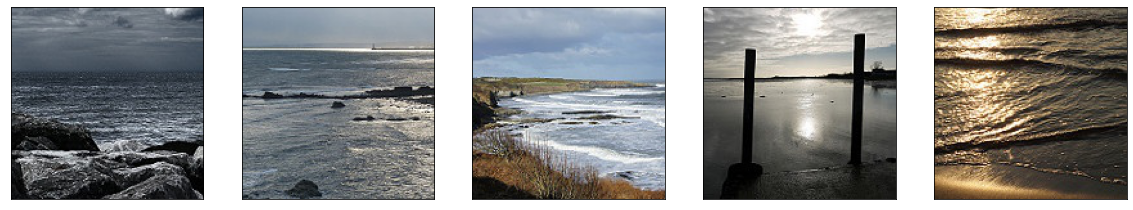

bosques


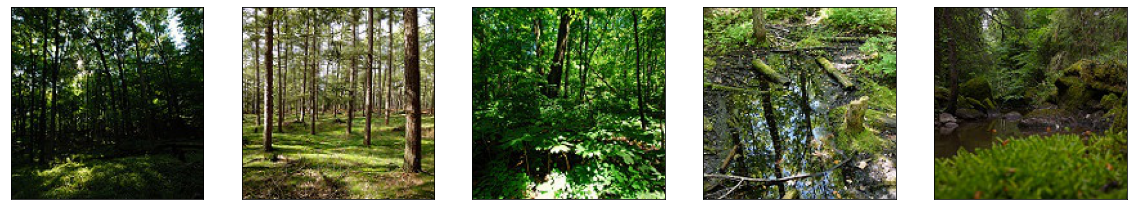

calles


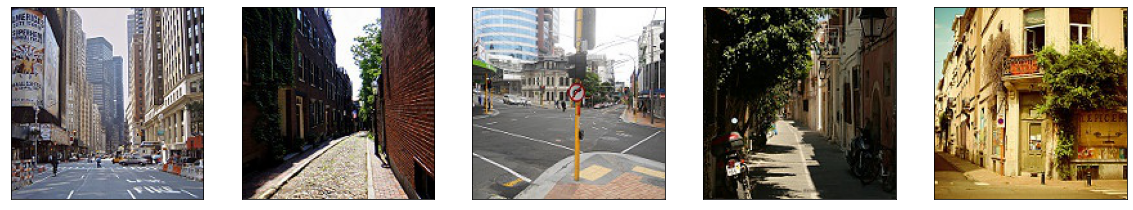

In [6]:
np.random.seed(RANDOM_SEED)
for category in CATEGORIES.keys():
    print(category)
    category_df = dataframes["train"][dataframes["train"]["label"] == category]
    fig, ax = plt.subplots(1, 5, figsize=(20, 8))
    for i, index in enumerate(np.random.randint(0, len(category_df), size=(5,))):
        show_image(category_df["img"].iloc[index], ax=ax[i])
    plt.show()

Lo primero que podemos detectar es que hay una imagen con un tamaño distinto al resto en la categoría de `glaciares`. Es algo que tendremos que tratar más adelante. Podemos ver otras cosas, como que el color va a ser un elemento muy relevante a la hora de decidir si la imagen pertenece a `bosques` o a `glaciares`. También vemos que va a ser difícil distinguir entre `montanas` y `glaciares`, y entre `calles` y `edificios`.

### 2.1 Proporción de clases en los datos

Un aspecto importante del que nos tenemos que preocupar es que las clases estén equilibradas en el conjunto de entrenamiento. Una clase demasiado predominante nos puede dar problemas sesgando a los modelos, así que vamos a elaborar gráficos para comprobar si es el caso.

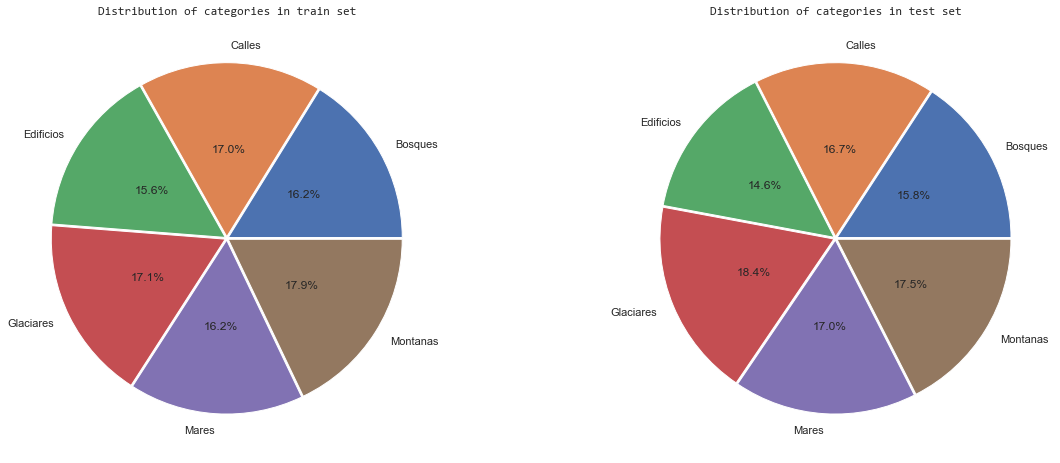

In [7]:
sns.set_theme()
fig, ax = plt.subplots(1, 2, figsize=(20, 8))
for i, dataset in enumerate(DATASETS):
    counts = dataframes[dataset]["label"].value_counts()
    counts = {key: val for key, val in sorted(counts.items(), key=lambda x: x[0])}
    ax[i].pie(x=list(counts.values()), autopct="%.1f%%", explode=[0.01]*len(counts), labels=[l.title() for l in counts.keys()], pctdistance=0.5)
    ax[i].set_title(f"Distribution of categories in {dataset} set", fontdict={"size": 14, "font": "Consolas"})

La distribución de las etiquetas es casi uniforme. Esto va a ser beneficioso para el entrenamiento.

### 2.2 Tamaños inconsistentes en las imágenes

En el enunciado del problema nos dicen que todas las imágenes tienen un tamaño de 150x150 píxeles. Sin embargo, en una muestra aleatoria que hemos escogido hemos visto una imagen que claramente tiene otro tamaño. Vamos a ver si se da en otros ejemplos.

In [8]:
for dataset in DATASETS:
    shapes = dataframes[dataset]["img"].apply(lambda x: x.shape).sort_values()
    print(f"Shapes in {dataset}")
    print(shapes.value_counts())

Shapes in train
(150, 150, 3)    13986
(113, 150, 3)        7
(135, 150, 3)        3
(111, 150, 3)        3
(123, 150, 3)        2
(142, 150, 3)        2
(144, 150, 3)        2
(108, 150, 3)        2
(134, 150, 3)        2
(146, 150, 3)        2
(143, 150, 3)        2
(136, 150, 3)        2
(119, 150, 3)        1
(133, 150, 3)        1
(100, 150, 3)        1
(140, 150, 3)        1
(131, 150, 3)        1
(149, 150, 3)        1
(105, 150, 3)        1
(141, 150, 3)        1
(115, 150, 3)        1
(76, 150, 3)         1
(110, 150, 3)        1
(120, 150, 3)        1
(147, 150, 3)        1
(102, 150, 3)        1
(103, 150, 3)        1
(145, 150, 3)        1
(81, 150, 3)         1
(124, 150, 3)        1
(97, 150, 3)         1
Name: img, dtype: int64
Shapes in test
(150, 150, 3)    2993
(72, 150, 3)        1
(110, 150, 3)       1
(76, 150, 3)        1
(141, 150, 3)       1
(81, 150, 3)        1
(149, 150, 3)       1
(131, 150, 3)       1
Name: img, dtype: int64


En todos estos casos nos faltan filas completas de píxeles: el número de columnas siempre es 150 (el esperado) y el número de filas es siempre inferior a 150. Podríamos plantearnos hacer un *padding* y completar estas filas con ceros, pero ya que nos faltan relativamente pocas filas (excepto en unas pocas instancias) podremos simplemente hacer un *resize* al tamaño adecuado.

### 2.3 Análisis de exposición

Vamos a mirar si nos puede interesar regular la exposición de las imágenes.

En un plot, vamos a mostrar las imágenes antes y después de corregir su exposición, para ver si hacerlo puede ayudar al entrenamiento.

edificios


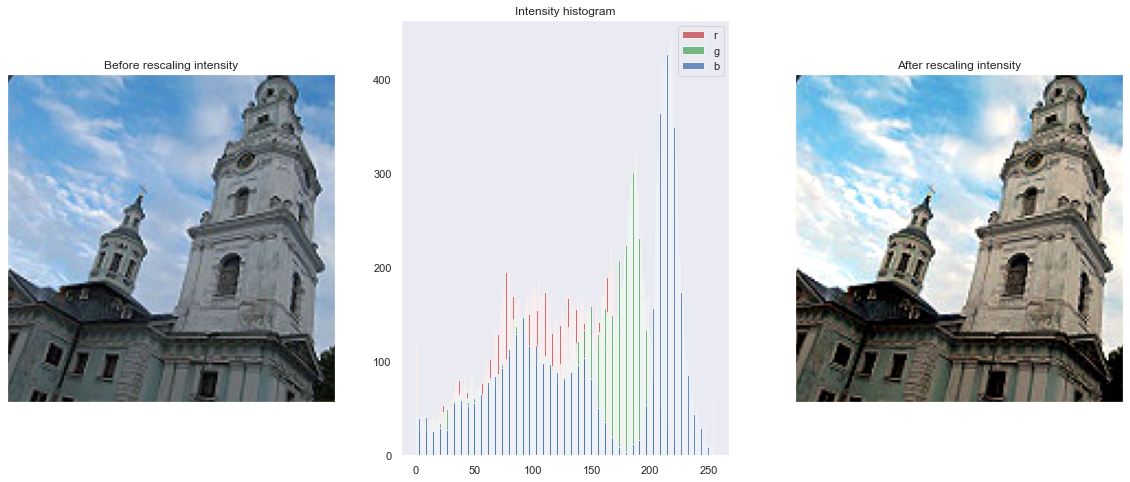

glaciares


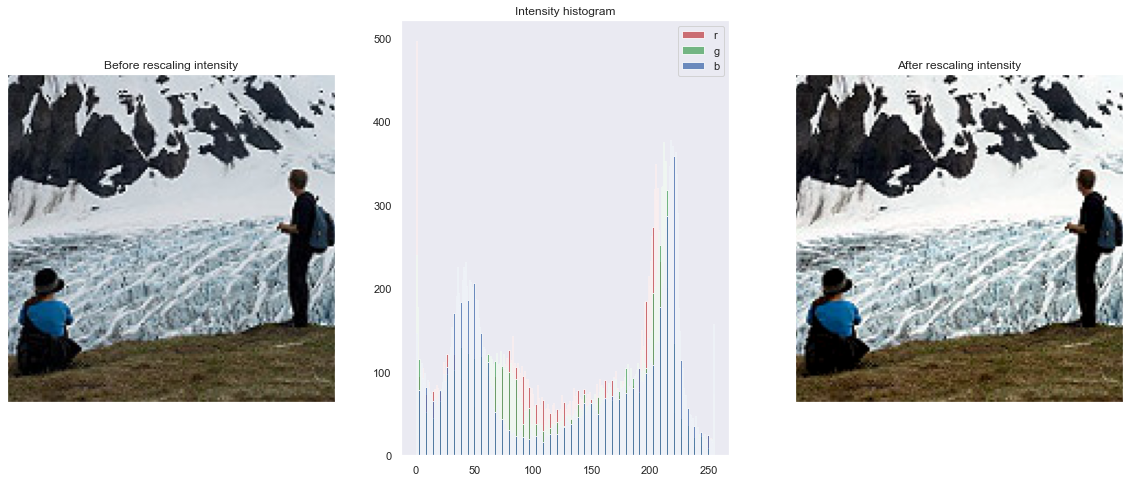

montanas


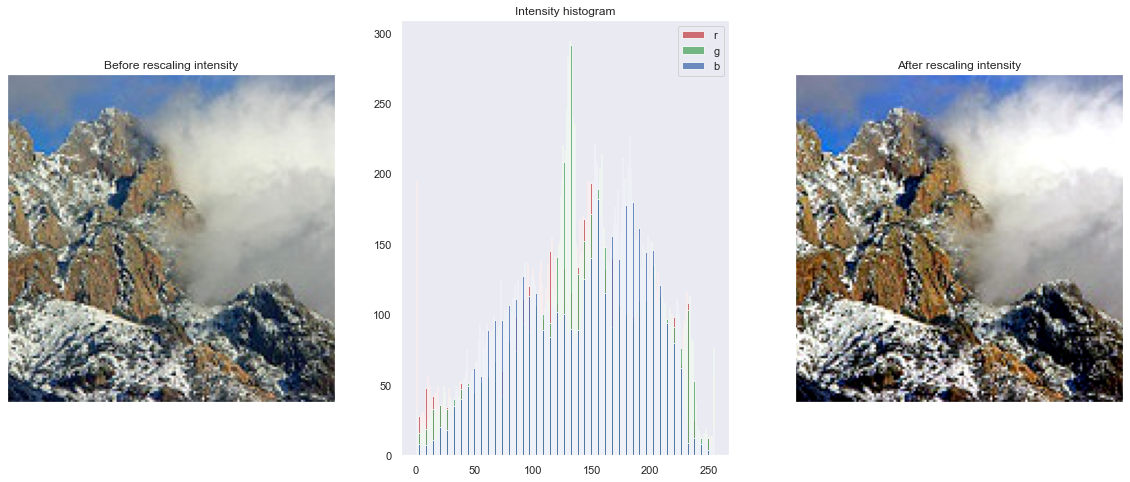

mares


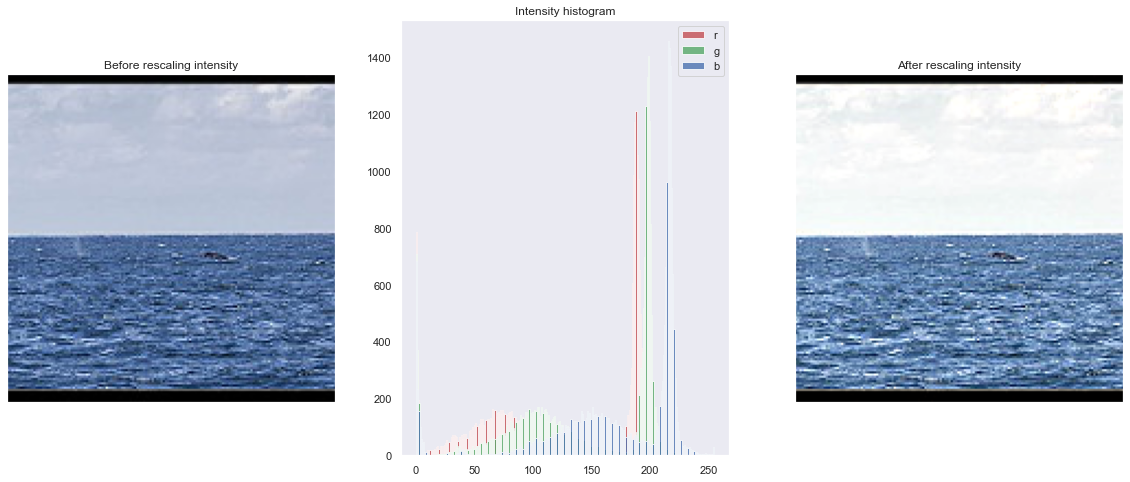

bosques


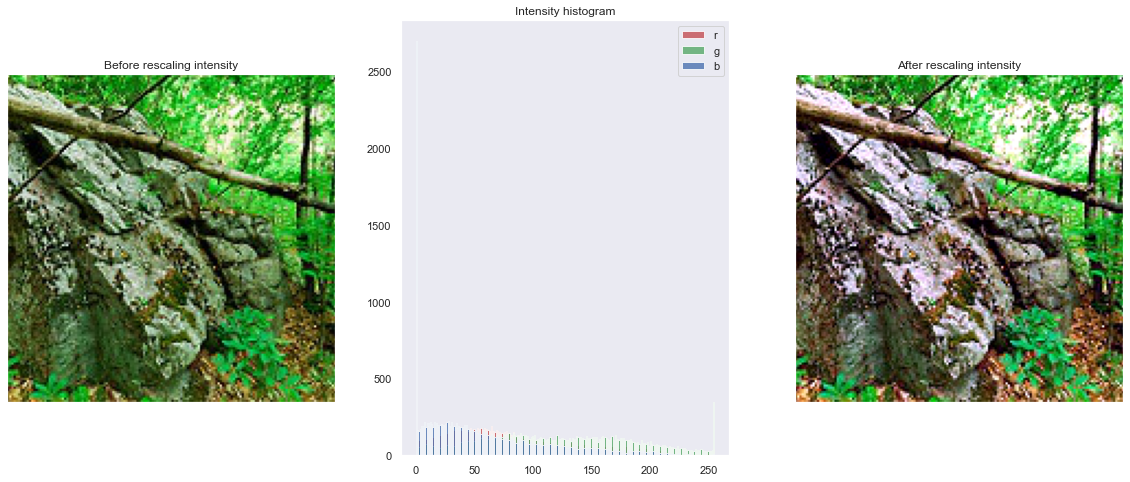

calles


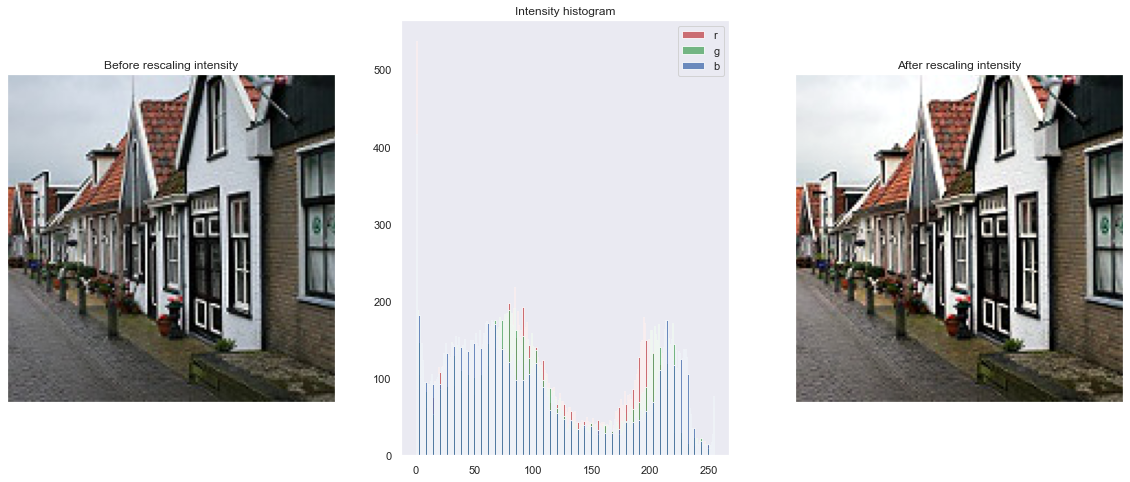

In [9]:
sns.set_style("dark")
for category, index in zip(CATEGORIES.keys(), np.random.randint(0, len(category_df), size=len(CATEGORIES))):
    
    print(category)
    category_df = dataframes["train"][dataframes["train"]["label"] == category]
    
    fig, ax = plt.subplots(1, 3, figsize=(20, 8))
    image = category_df["img"].iloc[index]   
    show_image(image, ax=ax[0], title="Before rescaling intensity")
    
    rgb = [image[:, :, color] for color in [0, 1, 2]]
    img_corrected = np.zeros_like(image)
    for color, color_index in zip(["r", "g", "b"], [0, 1, 2]):
        single_color_image = image[:, :, color_index]
        ax[1].hist(single_color_image.ravel(), bins=255, color=color, label=color, alpha=0.8)
        p_min, p_max = np.percentile(single_color_image, (5, 95))
        img_corrected[:, :, color_index] = rescale_intensity(single_color_image, in_range=(p_min, p_max))
    ax[1].legend()
    ax[1].set_title("Intensity histogram")
    
    show_image(img_corrected, ax=ax[2], title="After rescaling intensity")
    
    plt.show()

Parece que este paso consigue que la calidad de la imagen en general mejore ligeramente. Por tanto, será un paso del preprocesamiento.

### 2.4 Imágenes en blanco y negro

Como hemos visto, el color va a jugar un papel fundamental para distinguir algunas clases (como la diferencia entre montañas y glaciares). Por eso, las imágenes en blanco y negro podrían añadir ruido al modelo. Vamos a ver si hay muchas de esas.

650 grayscale images in train set


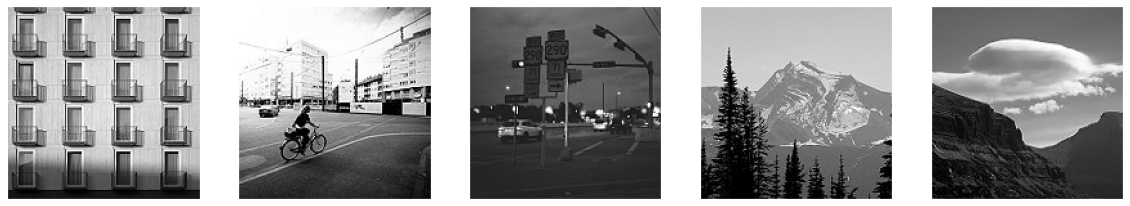

147 grayscale images in test set


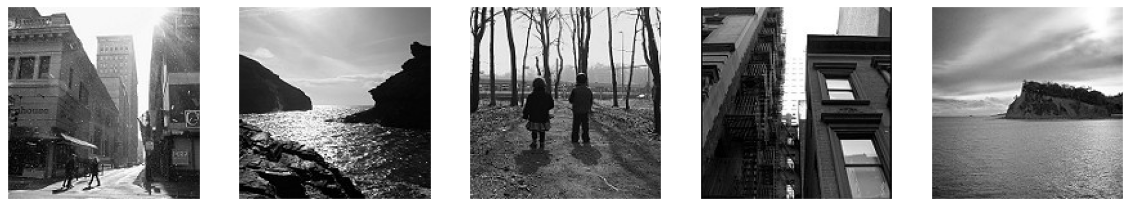

In [10]:
def is_black_white(image):
    if len(image.shape) == 2:
        return True
    else:
        assert image.shape[-1] == 3
        channels = [image[:, :, i] for i in range(3)]
        eq1 = abs(channels[0] - channels[1]).mean() < 75
        eq2 = abs(channels[1] - channels[2]).mean() < 75
        eq3 = abs(channels[2] - channels[0]).mean() < 75
        return eq1 and eq2 and eq3

bw = {}
for dataset in DATASETS:
    isbw = dataframes[dataset]["img"].apply(is_black_white)
    bw[dataset] = isbw[isbw]
    print(f"{len(bw[dataset])} grayscale images in {dataset} set")

    fig, ax = plt.subplots(1, 5, figsize=(20, 8))
    for i, index in enumerate(bw[dataset].sample(n=5, random_state=RANDOM_SEED).index):
        ax[i].imshow(dataframes[dataset]["img"].iloc[index])
        ax[i].grid()
        ax[i].set_xticks([])
        ax[i].set_yticks([])
    plt.show()

Ahora vamos a eliminar las imágenes correspondientes.

In [11]:
for dataset in DATASETS:
    dataframes[dataset].drop(bw[dataset].index, inplace=True)
del bw

## 3. Aumentación de los datos

Los mejores modelos de clasificación de imágenes siempre utilizan aumentación de los datos \[1\]. Esto es el proceso de generar nuevas imágenes a partir de las existentes. La idea principal es que más datos suele ser mejor, aunque los datos no sean totalmente correctos. Aunque suele usarse sobre todo para modelos de deep learning, también es beneficioso con modelos como los que vamos a utilizar aquí \[2\].

Nosotros vamos a aumentar los datos de entrenamiento a cuatro veces el número de imágenes disponibles mediante rotaciones muy básicas. No hacemos nada más complejo por restricciones de las máquinas en las que trabajamos.

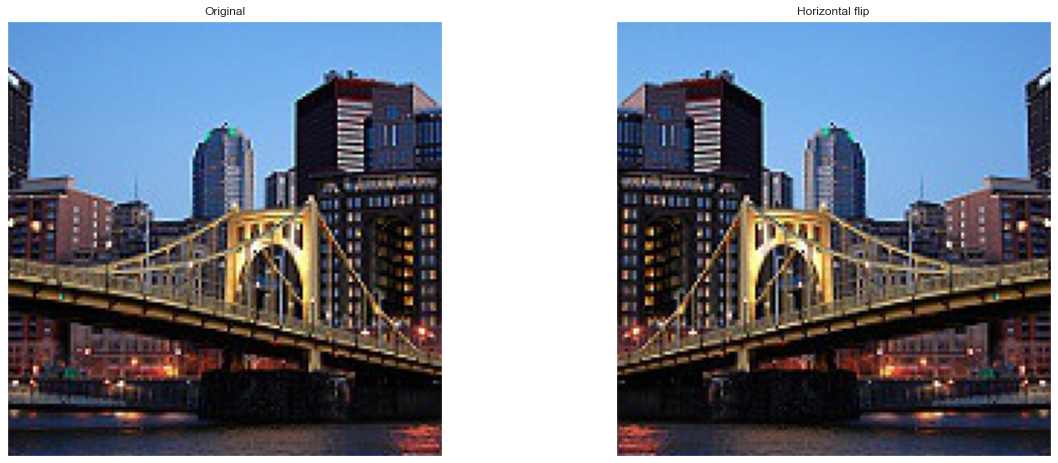

In [12]:
def horizontal_flip(img):
    return img[:, ::-1]

img = dataframes["train"]["img"].iloc[0]
fig, ax = plt.subplots(1, 2, figsize=(20, 8))
show_image(img, ax=ax[0], title="Original")
show_image(horizontal_flip(img), ax=ax[1], title="Horizontal flip")
plt.show()

In [13]:
for index, row in dataframes["train"].iterrows():
    dataframes["train"] = dataframes["train"].append({
        "img": horizontal_flip(row["img"]),
        "label": row["label"]
    }, ignore_index=True)

## 3. Preprocesamiento

Vamos a empezar a montar el pipeline de preprocesamiento para las imágenes. Lo primero que vamos a hacer es barajar los `DataFrames` y convertirlos en arrays de NumPy.

In [14]:
dataframes["train"] = dataframes["train"].sample(frac=1, random_state=RANDOM_SEED)
dataframes["test"] = dataframes["test"].sample(frac=1, random_state=RANDOM_SEED)

X_train, y_train = dataframes["train"]["img"].to_numpy(), dataframes["train"]["label"].to_numpy()
X_test, y_test = dataframes["test"]["img"].to_numpy(), dataframes["test"]["label"].to_numpy()
del dataframes

gc.collect()
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((26768,), (26768,), (2853,), (2853,))

### 3.1 *Resize*

Vamos a añadir un componente `resize_image` para que todas las imágenes tengan el tamaño deseado. Utilizamos [resize](https://scikit-image.org/docs/dev/api/skimage.transform.html?highlight=resize#skimage.transform.resize) del paquete `skimage.transform`, que no modifica la imagen si ya tiene las dimensiones especificadas.

In [15]:
def resize_funct(X, output_shape=OUTPUT_SHAPE):
    ret = np.zeros((len(X), *output_shape))
    for index, image in enumerate(X):
        ret[index] = resize(image, output_shape=output_shape)
    return ret

resize_image = FunctionTransformer(resize_funct)

### 3.3 Aplicación de una máscara

Vamos a enmascarar, es decir, ignorar, parte de las imágenes. Esto simplificará mucho el entrenamiento reduciendo el espacio de búsqueda a las partes más relevantes de la imagen. Vamos a eliminar la parte de las esquinas en un radio de $\frac{x}{2}$, siendo $x$ el lado de la imagen.

In [16]:
assert OUTPUT_SHAPE[0] == OUTPUT_SHAPE[1]

channel_mask = np.zeros((OUTPUT_SHAPE[0], OUTPUT_SHAPE[1]), dtype=bool)
channel_mask[:OUTPUT_SHAPE[0] // 5] = True
MASK = np.concatenate([np.expand_dims(channel_mask, -1)] * 3, axis=-1) # Apply mask to all three channels


def apply_mask(X):
    full_mask = np.concatenate([np.expand_dims(MASK, 0)] * len(X), axis=0)
    return np.ma.masked_array(X, mask=full_mask)


masker = FunctionTransformer(apply_mask)

### 3.2 Ajuste de la exposición

Podemos hacer el ajuste de la intensidad de los píxeles, como hemos visto anteriormente, para mejorar ligeramente la calidad de la imagen.

In [17]:
def adjust_exposure_funct(X):
    ret = np.zeros_like(X, dtype=np.int)
    for index, image in enumerate(X):
        for channel in [0, 1, 2]:
            channel_image = image[:, :, channel]
            pmin, pmax = np.percentile(channel_image, (5, 95))
            ret[index, :, :, channel] = rescale_intensity(channel_image, in_range=(pmin, pmax))
            
    return np.ma.masked_array(ret, mask=X.mask)

adjust_exposure = FunctionTransformer(adjust_exposure_funct)

### 3.4 *Flatten*

Lo siguiente va a ser convertir las imágenes en una fila de una sola dimensión. Para ello vamos a usar el método [`compressed`](https://numpy.org/devdocs/reference/generated/numpy.ma.MaskedArray.compressed.html#numpy.ma.MaskedArray.compressed) de los arrays con máscara de NumPy, que convertirá en una fila sólo los valores no enmascarados.

In [18]:
def flatten_array(X):
    if isinstance(X, np.ma.MaskedArray):    
        return np.array([x.compressed() for x in X])
    else:
        return np.array([x.flatten() for x in X])


flatten = FunctionTransformer(flatten_array)

### 3.5 *Scale*

Escalamos cada uno de los píxeles (dividido por canal) convirtiendo cada dato al rango 0-1. No necesitamos preocuparnos del tipo de escalado porque todas las features ya están en el mismo rango, de 0 a 255. En realidad, este paso es un simple trámite para reducir la escala de los valores con los que se trabaja.

In [19]:
scaling = FunctionTransformer(lambda X: X / 255)

### 3.6 PCA

En último lugar, queremos reducir la dimensionalidad de los datos. En total, después de todo el proceso, tendremos $n_{train} \cdot 4 + n_{test}$ imágenes, siendo $n_{train}$ el número de imágenes original en entrenamiento y $n_{test}$ en test. Cada una de estas imágenes tiene $150 \times 150 \times 3$ datos antes de aplicar la máscara. Después de esta máscara el número de datos por imagen es $\pi \cdot \left( \frac{150}{2} \right)^2 \cdot 3 \approx 53014$ features distintas por fila de datos. Esto es exagerado para nuestros datos, así que tenemos que reducir la dimensionalidad. Utilizaremos el algoritmo [`PCA`](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html#sklearn.decomposition.PCA) aplicado a cada canal RGB por separado.

In [20]:
class SplitTransformer(BaseEstimator, TransformerMixin):
    """
    Apply a scikit-learn transformer to individual slices of a multi-dimensional array.
    """
    def __init__(transformer=PCA,
                 axis=0,
                 transformer_kwargs={}):
        """
        transformer: Scikit-learn Transformer class. Must implement `fit` and `transform` methods.
        axis: axis by which input will be divided.
        random_state: RandomState object, int or None. Will be passed to transformer if necessary.
        transformer_kwargs: keyword arguments to be passed to transformer constructor.
        """
        self.transformer_class = transformer
        self.axis = axis
        self.transformer_kwargs = transformer_kwargs

        
    def fit(X, y=None):
        self.shape = X.shape
        self.n_splits = X.shape[self.axis]
        self.splits = np.split(X, self.n_splits, axis=self.axis)
        self.transformers = [self.transformer_class(**transformer_kwargs)] * self.n_splits
        for i in range(self.n_splits):
            self.transformers[i].fit(self.splits[i])
    
    def transform(X, y=None):
        if X.shape != self.shape:
            raise ValueError(f"Shape mismatch: expected {self.shape}, got {X.shape}")
            
        ret = np.zeros_like(X)
        splits = np.split(X, self.n_splits, axis=self.axis)
        for i in range(self.n_splits):
            ret[i] = self.transformers[i].transform(splits[i])
            
        return ret

In [21]:
pca = PCA(n_components = 100, svd_solver="auto", random_state=RANDOM_SEED)

### 3.7 Pipeline completo y preprocesamiento de los datos en batch

Además de montar el pipeline completo para las imágenes, vamos a codificar las etiquetas en arrays numéricos.

In [22]:
full_pipeline = Pipeline([
    ("resize", resize_image),
    #("mask", masker),
    #("adjust_exposure", adjust_exposure),
    ("flatten", flatten),
    #("scaling", scaling),
    #("pca", pca)
], verbose=True)

label_encoder = FunctionTransformer(lambda y: [CATEGORIES[elem] for elem in y])

In [23]:
gc.collect()

60

El tamaño de los datos hace que sea imposible tratarlo todo en memoria. Es por eso que vamos a hacer un bucle para tratar los datos en minibatches. Como casi todas las transformaciones son únicas para cada imagen y no dependen del resto, esto es factible y no molesta demasiado. La única que se puede ver perjudicada es la de PCA, pero mientras los minibatches sean suficientemente grandes no habrá ningún problema.

In [24]:
batch_count = len(X_train) // BATCH_SIZE
assert len(X_train) == len(y_train)
data_batches = np.array_split(X_train, batch_count)
label_batches = np.array_split(y_train, batch_count)

for i, data_batch, label_batch in zip(range(batch_count), data_batches, label_batches):
    print(f"Processing batch {i + 1} of {batch_count}...")
    assert len(data_batch) == len(label_batch)
    
    transformed_batch = full_pipeline.fit_transform(data_batch)
    np.save(os.path.join(DATA_PATH, f"X_train_preprocessed_batch{i}.npy"), transformed_batch)
    print(f"Output shape: {transformed_batch.shape}")
    
    transformed_label_batch = label_encoder.fit_transform(label_batch)
    np.save(os.path.join(DATA_PATH, f"y_train_preprocessed_batch{i}.npy"), transformed_label_batch)
    
    gc.collect()

print("\nProcessing transform on test...")
X_test_preprocessed = full_pipeline.transform(X_test)
y_test_preprocessed = label_encoder.transform(y_test)
np.save(os.path.join(DATA_PATH, "X_test_preprocessed.npy"), X_test_preprocessed)
np.save(os.path.join(DATA_PATH, "y_test_preprocessed.npy"), y_test_preprocessed)
del X_test, y_test
gc.collect()
print("Done.")

Processing batch 1 of 6...
[Pipeline] ............ (step 1 of 2) Processing resize, total=  18.1s
[Pipeline] ........... (step 2 of 2) Processing flatten, total=   0.2s
Output shape: (4462, 7500)
Processing batch 2 of 6...
[Pipeline] ............ (step 1 of 2) Processing resize, total=  10.8s
[Pipeline] ........... (step 2 of 2) Processing flatten, total=   0.2s
Output shape: (4462, 7500)
Processing batch 3 of 6...
[Pipeline] ............ (step 1 of 2) Processing resize, total=  22.1s
[Pipeline] ........... (step 2 of 2) Processing flatten, total=   0.2s
Output shape: (4461, 7500)
Processing batch 4 of 6...
[Pipeline] ............ (step 1 of 2) Processing resize, total=  20.7s
[Pipeline] ........... (step 2 of 2) Processing flatten, total=   0.2s
Output shape: (4461, 7500)
Processing batch 5 of 6...
[Pipeline] ............ (step 1 of 2) Processing resize, total=  24.9s
[Pipeline] ........... (step 2 of 2) Processing flatten, total=   0.2s
Output shape: (4461, 7500)
Processing batch 6 o

In [25]:
X_train_preprocessed = []
y_train_preprocessed = []
for batch_num in range(batch_count):
    X_train_preprocessed.append(np.load(os.path.join(DATA_PATH, f"X_train_preprocessed_batch{batch_num}.npy")))
    y_train_preprocessed.append(np.load(os.path.join(DATA_PATH, f"y_train_preprocessed_batch{batch_num}.npy")))
    
X_train_preprocessed = np.concatenate(X_train_preprocessed, axis=0)
y_train_preprocessed = np.concatenate(y_train_preprocessed, axis=0)

X_test_preprocessed = np.load(os.path.join(DATA_PATH, "X_test_preprocessed.npy"))
y_test_preprocessed = np.load(os.path.join(DATA_PATH, "y_test_preprocessed.npy"))

X_train_preprocessed.shape, y_train_preprocessed.shape, X_test_preprocessed.shape, y_test_preprocessed.shape

((26768, 7500), (26768,), (2853, 7500), (2853,))

## 4. Entrenamiento y evaluación de modelos

El siguiente paso es el diseño, entrenamiento y evaluación de los distintos modelos. Vamos a definir las métricas, la tabla de resultados y las funciones de entrenamiento y evaluación.

In [26]:
Metric = namedtuple("Metric", ("name", "funct"))
metrics = [
    Metric("accuracy", accuracy_score),
    Metric("confusion_matrix", confusion_matrix),
    Metric("f1", lambda y_true, y_pred: f1_score(y_true, y_pred, average="macro"))
]

results_df = pd.DataFrame(columns=[
    "model", "accuracy", "f1", "confusion_matrix", "best_params"
])

In [27]:
def train_model(X, y, estimator, param_grid):

    gridsearch = GridSearchCV(estimator,
                              param_grid=param_grid,
                              scoring="accuracy",
                              cv=CV_FOLDS,
                              refit=True,
                              verbose=1)

    gridsearch.fit(X, y)

    return gridsearch.best_estimator_, gridsearch.best_params_


def evaluate_model(model, X, y, metrics=metrics):
    scores = {}

    predictions = model.predict(X)
    for metric in metrics:
        scores[metric.name] = metric.funct(y_true=y, y_pred=predictions)

    return scores

### 4.1 RandomForestClassifier

In [28]:
param_grid = {
    "n_estimators": [300],
    "bootstrap": [True],
    "min_samples_split": [10],
    "max_depth": [None, 10],
    "min_samples_leaf": [5], 
}

model = RandomForestClassifier(random_state=RANDOM_SEED)

random_forest, random_forest_params = train_model(X_train_preprocessed, y_train_preprocessed, model, param_grid)
random_forest_scores = evaluate_model(random_forest, X_test_preprocessed, y_test_preprocessed, metrics=metrics)

random_forest_results = pd.Series(
    {**{"model": "RandomForest", "best_params": random_forest_params}, **random_forest_scores}
)
display(random_forest_results)

results_df = results_df.append(random_forest_results, ignore_index=True)

Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed: 62.1min finished


model                                                    RandomForest
best_params         {'bootstrap': True, 'max_depth': None, 'min_sa...
accuracy                                                      0.62075
confusion_matrix    [[193, 40, 55, 28, 43, 55], [26, 357, 92, 42, ...
f1                                                           0.613364
dtype: object

In [29]:
evaluate_model(random_forest, X_train_preprocessed, y_train_preprocessed, metrics=metrics)

{'accuracy': 0.9704871488344292,
 'confusion_matrix': array([[4042,   17,   18,    1,   50,   50],
        [   4, 4606,   84,    1,   43,   26],
        [   3,   87, 4817,    5,   51,   13],
        [   6,   26,   35, 4252,   47,   14],
        [  11,   12,   46,   17, 4297,   21],
        [  13,   16,   38,   18,   17, 3964]]),
 'f1': 0.9708771726628939}

In [30]:
print(CATEGORIES)
evaluate_model(random_forest, X_test_preprocessed, y_test_preprocessed, metrics=metrics)

{'edificios': 0, 'glaciares': 1, 'montanas': 2, 'mares': 3, 'bosques': 4, 'calles': 5}


{'accuracy': 0.6207500876270592,
 'confusion_matrix': array([[193,  40,  55,  28,  43,  55],
        [ 26, 357,  92,  42,  10,  21],
        [ 32,  68, 354,  44,  15,   9],
        [ 33, 120,  77, 199,  43,   8],
        [ 19,   1,   8,   3, 381,  39],
        [ 45,  27,  15,  12,  52, 287]]),
 'f1': 0.613364100020845}

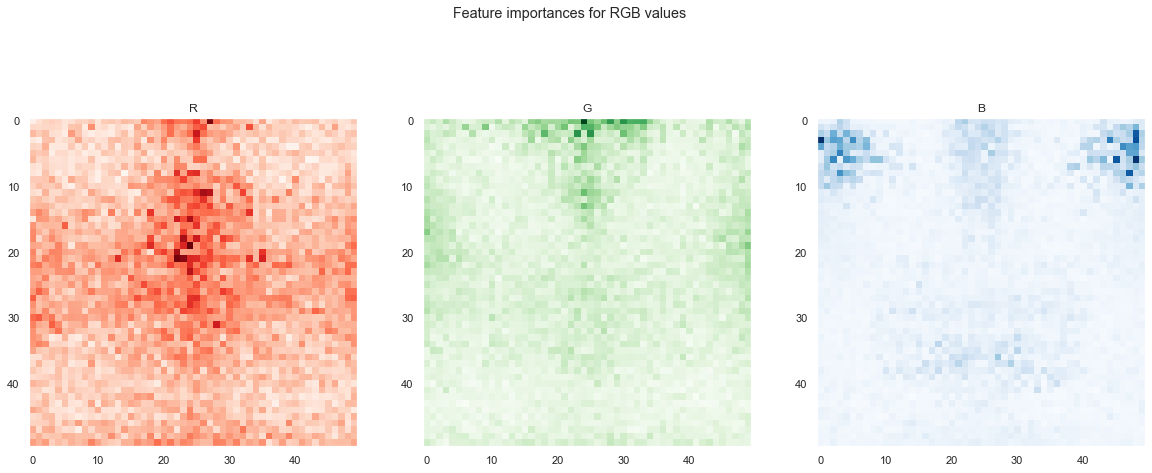

In [40]:
importances = random_forest.feature_importances_.reshape(50, 50, 3)
fig, ax = plt.subplots(1, 3, figsize=(20, 8))
ax[0].imshow(importances[:, :, 0], cmap="Reds"); ax[0].set_title("R")
ax[1].imshow(importances[:, :, 1], cmap="Greens"); ax[1].set_title("G")
ax[2].imshow(importances[:, :, 2], "Blues"); ax[2].set_title("B")
fig.suptitle("Feature importances for RGB values")
plt.show()

### 4.2 *OvR* Logistic Regression

Lo que buscábamos implementar en este caso es un conjunto de seis modelos de regresión logística, uno por clase, en el que la predicción final sería la del modelo que estuviera más convencido (probabilidad más cercana a 1).

Según nos hemos dado cuenta, la clase LogisticRegression ya implementa este comportamiento, si se escogen los parámetros adecuados.

In [31]:
model = LogisticRegression(multi_class="ovr", solver="sag", penalty="l2", random_state=RANDOM_SEED)

ovr_logistic, ovr_logistic_params = train_model(X_train_preprocessed, y_train_preprocessed, model, param_grid)
ovr_logistic_scores = evaluate_model(ovr_logistic, X_test_preprocessed, y_test_preprocessed, metrics=metrics)

ovr_logistic_results = pd.Series(
    {**{"model": "OvRLogisticRegression", "best_params": ovr_logistic_params}, **ovr_logistic_scores}
)
display(ovr_logistic_results)

results_df = results_df.append(ovr_logistic_results, ignore_index=True)

Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/home/diego/venv/ml/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diego/venv/ml/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/diego/venv/ml/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/diego/venv/ml/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    "got %s penalty." % (solver, penalty))
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)


KeyboardInterrupt: 

In [ ]:
evaluate_model(ovr_logistic, X_train_preprocessed, y_train_preprocessed, metrics=metrics)

### 4.3 XGBoost

Por último, vamos a utilizar XGBoost. El modelo XGBoost (X-treme Gradient Boosting) es un modelo que utiliza boosting de árboles de decisión básicos, con algunas mejoras. Es un modelo que a menudo gana en las competiciones de Kaggle. Vamos a hacer una implementación básica, sin muchas de las funcionalidades u optimizaciones.

### 4.4 Resultados

In [ ]:
# TODO

## 5. Conclusiones

\# TODO

## 6. Referencias

\[1\] ImageNet SOTA: https://paperswithcode.com/sota/image-classification-on-imagenet.

---
Creado por **Diego Trujillo** (diego.trujillo.jimenez@alumnos.upm.es) y **Ángel Acevedo** (angel.acevedo.sanchez@alumnos.upm.es) 

<br></br>
[![License: GPL v2](https://img.shields.io/badge/License-GPL%20v2-blue.svg)](https://www.gnu.org/licenses/old-licenses/gpl-2.0.en.html)